In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # specify the path of the folder containing "file_name" :
    path_to_file = '/content/gdrive/My Drive/BT5153_2023/codes/lab_lecture06'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/BT5153_2022/codes/week6_cnn/
/content/gdrive/My Drive/BT5153_2022/codes/week6_cnn


# How CNN see and understand Image Data

The convolutional network (CNN), that is especially suited for feature extraction of image data. A CNN is a neural network typically composed of two components:
1. one component for extracting useful features of the data: **Convolutional Layer** and **Pooling Layer**

2. another for performing a ML task (like classification based on the featurized data): **Fully-connected Layer**

In this notebook, we will focus on feature extraction parts behind CNN, i.e., convolutional layer and pooling layer. We hope you can gain more understanding about CNN through this section. 

##### Filter Operation

![](https://github.com/rz0718/colab_imgs/blob/main/imgs/filter.gif?raw=true)


##### Pooling Operation

![](https://github.com/rz0718/colab_imgs/blob/main/imgs/pool.png?raw=true)


### Warm-Up

Prepare the image "T" as a 2D Numpy array. And visualize it.

In [2]:
import numpy as np
img = np.array([
[1,1,1,1,1,1],
[1,1,1,1,1,1],
[0,0,1,1,0,0],
[0,0,1,1,0,0],
[0,0,1,1,0,0],
[0,0,1,1,0,0],]
)

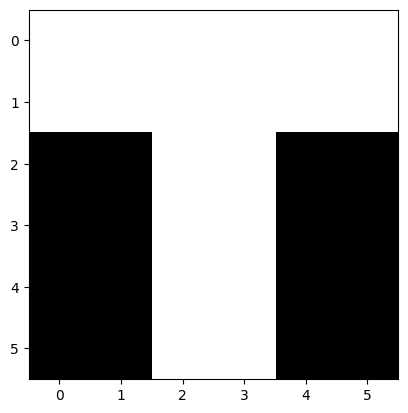

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(img, cmap='gray')

Generate the kernel

In [4]:
filters = np.array([[1, 1, 1],
                  [1, 1, 1],
                  [0, 0, 0]])

Use this kernel and convolve over the image with same border mode (with [scipy.signal.convolve2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html)).**

In [5]:
from scipy.signal import convolve2d
fil_imgs = convolve2d(img, filters, mode='same')

Plot the image.

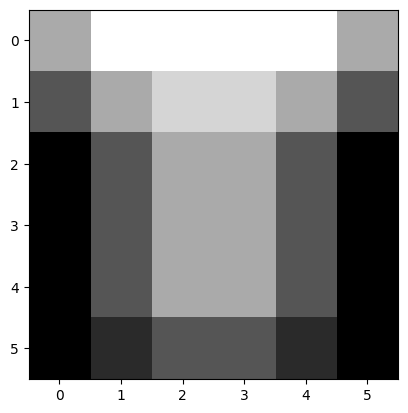

In [6]:
plt.imshow(fil_imgs, cmap='gray')

Take a moment to examine the convolved images. You should see that convolutional filters can both accentuate and dampen specific features in input images such as curves, edges or colours. .

Now you may design a new filter as [[1, 1, 0], [1, 1, 0],[1, 1, 0]]. And check the results

In [7]:
filters_2 = np.array([[1, 1, 0],
                      [1, 1, 0],
                      [1,1, 0]])

In [8]:
filters_2

array([[1, 1, 0],
       [1, 1, 0],
       [1, 1, 0]])

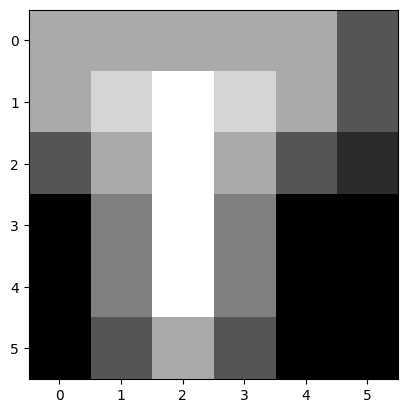

In [9]:
fil_imgs2 = convolve2d(img, filters_2, mode='same')
plt.imshow(fil_imgs2, cmap='gray')

1. **Different convolutional filters extract different features** 
2. it is the combination of the resulting feature maps that powers the CNNs predictions. 
3. In the following, we add non-linear activation and pooling functions on a real image

### Part 2:  Pokemon Convolution!

Yup, it is not Pokemon go.

Consider the following image of a pikka, which you will find in `pokemon.png`:


<img src="../data/pokemon.png" width="50%" />

The image is already normalized into the scale [0, 1].

**Perform the following steps for four images:**

**1. Create the edge detection filter.**

As shown in the slide

**2. Use this kernel and convolve over the image with same border mode (with [scipy.signal.convolve2d])**

**3. Plot the image**

**4. In the resulting image, set all pixel values less than zero to zero (using np.clip()). In other words:**


`
if x < 0:
    x = 0
else:
    x = x
`

(What is the non-linear activation function?)

In [10]:
from matplotlib.image import imread
import numpy as np
img = imread('..//data//pokemon.png')

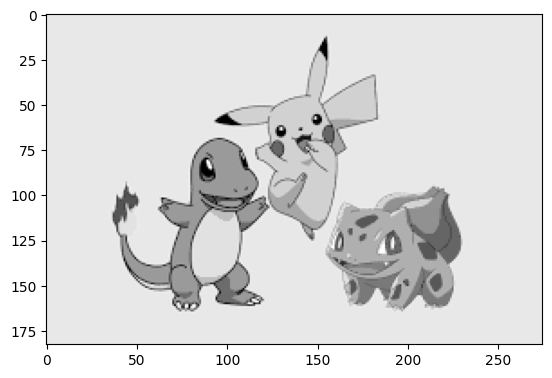

In [11]:
plt.imshow(img, cmap='gray')

In [12]:
print(img.max(), img.min())

1.0 0.0


In [13]:
img.shape

(183, 275)

In [14]:
# generate one kernel for edge detection
#kernel = np.random.rand(3,3)
kernel = np.array([[-1, 0,-1],
                      [0, 0,0],
                      [1, 0, 1]])

In [15]:
print(kernel)

[[-1  0 -1]
 [ 0  0  0]
 [ 1  0  1]]


In [16]:
# solution
conv_img = convolve2d(img, kernel, mode='same')

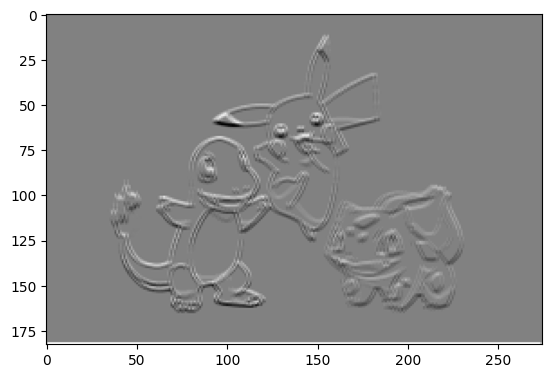

In [17]:
# here assume the conv_img is the output of the filter operation
plt.imshow(conv_img, cmap='gray')

In [18]:
# solution
conv_img_nonlinear = np.clip(conv_img, a_min=0, a_max=None)

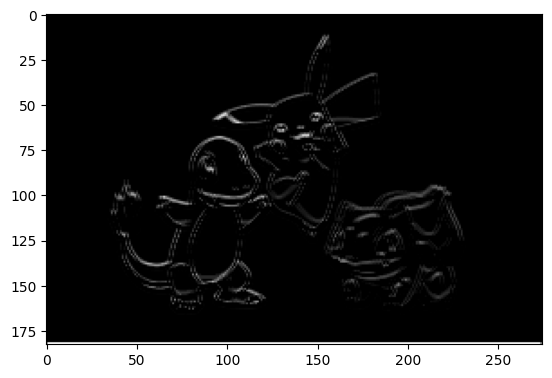

In [19]:
# here assume the conv_img_nonlinear is the output of the filter operation
plt.imshow(conv_img_nonlinear,cmap='gray')

https://en.wikipedia.org/wiki/Grayscale

#### Apply max-pooling operation over the image (https://stackoverflow.com/questions/42463172/how-to-perform-max-mean-pooling-on-a-2d-array-using-numpy)** 
Here, the pooling size is set to *(3, 3)*


In [21]:
# here assume the conv_img_nonlinear is the output of the filter operation
import skimage.measure
pool_img = skimage.measure.block_reduce(conv_img_nonlinear, (3,3), np.max)

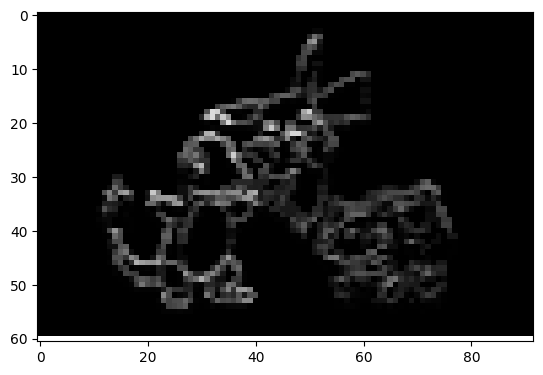

In [22]:
# here assume the conv_img_nonlinear is the output of the filter operation
plt.imshow(pool_img,cmap='gray')

In [23]:
# Then, this vector can be fed into the dense layers to predict the label
final_vec = pool_img.flatten()

### Part 3: Build CNN using Keras

Fortunately, we do not need to implement Convolutional and Pooling layer from stratch. We have already built a CNN model for Fashion-MNIST data. The gradients can be automatically computed and the model weights can then be learned. Then, we may ask ourselves What does a CNN learn? 

Let us firstly try a very simple CNN structure.

In [1]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras as keras
data = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test_all, y_test_all) = data.load_data()

In [2]:
class_names = [ "T-shirt/top", "Trouser", "Pullover", 
                "Dress", "Coat", "Sandal", "Shirt",
                "Sneaker", "Bag", "Ankle boot" ]
# take images from only two class: Sneaker and Ankle boot
x_train = x_train_all[(y_train_all == 7) | (y_train_all == 9)]
y_train = y_train_all[(y_train_all == 7) | (y_train_all == 9)]
y_train[y_train==7] = 0
y_train[y_train==9] = 1

In [3]:
x_train.shape

(12000, 28, 28)

In [4]:
x_test = x_test_all[(y_test_all == 7) | (y_test_all == 9)]
y_test = y_test_all[(y_test_all == 7) | (y_test_all == 9)]
y_test[y_test==7] = 0
y_test[y_test==9] = 1

In [5]:
x_test.shape

(2000, 28, 28)

In [6]:
y_train

array([1, 0, 1, ..., 1, 0, 0], dtype=uint8)

In [7]:
x_train = x_train.reshape(12000, 28, 28, 1)
x_test  = x_test.reshape(2000, 28, 28, 1)

x_val, x_train = x_train[:1000] / 255.0, x_train[1000:] / 255.0
y_val, y_train = y_train[:1000] , y_train[1000:] 

In [8]:
x_train.shape

(11000, 28, 28, 1)

In [9]:
kernel_size = (3, 3)
stride_size = (1, 1)
num_filters = 4

cnn_model = Sequential()
# feature extraction layer 0: convolution

cnn_model.add(Conv2D(num_filters, kernel_size=kernel_size,
                 activation='relu',
                 input_shape=(28, 28, 1)))
# feature extraction layer 1: max pooling
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
# classification layer 2: flattening
cnn_model.add(Flatten())
# classification layer 3: dense non-linear transformation
cnn_model.add(Dense(100, activation='relu'))
# classification layer 4: output label probability
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=0.01),
                  metrics=['accuracy'])

In [10]:
history = cnn_model.fit(x_train, 
          y_train, 
          epochs=20,
          validation_data=(x_val, y_val))

Epoch 1/20


2022-12-27 22:51:05.723110: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


344/344 [==============================] - 1s 3ms/step - loss: 0.1409 - accuracy: 0.9489 - val_loss: 0.0959 - val_accuracy: 0.9610
Epoch 2/20
344/344 [==============================] - 1s 2ms/step - loss: 0.0867 - accuracy: 0.9681 - val_loss: 0.0686 - val_accuracy: 0.9790
Epoch 3/20
344/344 [==============================] - 1s 2ms/step - loss: 0.0833 - accuracy: 0.9687 - val_loss: 0.0676 - val_accuracy: 0.9790
Epoch 4/20
344/344 [==============================] - 1s 2ms/step - loss: 0.0707 - accuracy: 0.9735 - val_loss: 0.0667 - val_accuracy: 0.9790
Epoch 5/20
344/344 [==============================] - 1s 2ms/step - loss: 0.0661 - accuracy: 0.9749 - val_loss: 0.0646 - val_accuracy: 0.9780
Epoch 6/20
344/344 [==============================] - 1s 2ms/step - loss: 0.0601 - accuracy: 0.9768 - val_loss: 0.0760 - val_accuracy: 0.9750
Epoch 7/20
344/344 [==============================] - 1s 3ms/step - loss: 0.0536 - accuracy: 0.9791 - val_loss: 0.0779 - val_accuracy: 0.9800
Epoch 8/20
344/34

In [11]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 4)         40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 4)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 676)               0         
                                                                 
 dense (Dense)               (None, 100)               67700     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 67,841
Trainable params: 67,841
Non-trainable params: 0
____________________________________________________

## Part 4. Let us crack the above CNN open

**What does CNN learn?** 

Now we want to get an intuitive understanding of what hidden layers i.e., conv. layers and pooling layers in a CNN are learning from the data.

Here, we are trying to find the answers from two persepctives. 

1. Visualize the learned filter weights.

2. Visualize the hidden layers' outputs given input images

### visualize the weights of the filters in the above CNN model. 

https://ai-pool.com/d/how-to-get-the-weights-of-keras-model-

In [12]:
# function to visualize images or weights from vector or matrix in grey scale
def plot_fig(figax, img, image_shape):
    vmax = max(img.max(), -img.min())
    figax.imshow(img.reshape(image_shape), cmap=plt.cm.gray,
              vmin=-vmax, vmax=vmax)
    return figax

In [13]:
# let us visualize two of the input images
fig, ax = plt.subplots(2, 1, figsize=(5, 8))
boot_x = x_train[0,:,:]
sneaker_x   = x_train[1,:,:]
ax[0] = plot_fig(ax[0], boot_x, (28, 28))
ax[1] = plot_fig(ax[1], sneaker_x, (28, 28))

NameError: name 'plt' is not defined

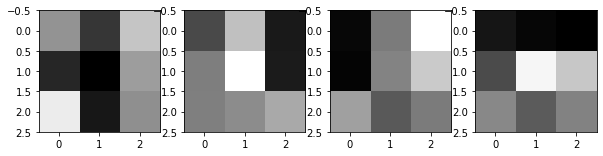

In [ ]:
# we visualize the four filters we learned
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0] = plot_fig(ax[0], cnn_model.layers[0].get_weights()[0][:, :, :, 0].flatten(), (3, 3))
ax[1] = plot_fig(ax[1], cnn_model.layers[0].get_weights()[0][:, :, :, 1].flatten(), (3, 3))
ax[2] = plot_fig(ax[2], cnn_model.layers[0].get_weights()[0][:, :, :, 2].flatten(), (3, 3))
ax[3] = plot_fig(ax[3], cnn_model.layers[0].get_weights()[0][:, :, :, 3].flatten(), (3, 3))
plt.show()

### visualize the output of the convolutional layer and the pooling layer separately. 

https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer


In [ ]:
# using the backend.function in keras

from tensorflow.keras import backend as K
#@tf.function
get_conv_layer_output = K.function([cnn_model.layers[0].input],
                                  [cnn_model.layers[0].output])
layer_output = get_conv_layer_output(np.expand_dims(boot_x, axis=0))[0]

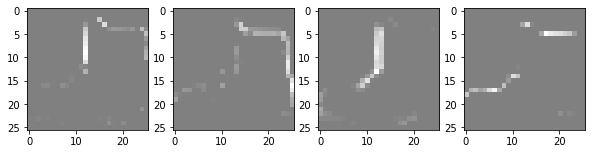

In [ ]:
# visualize a training image "boot_x" after it passes through the above four filters
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0] = plot_fig(ax[0], layer_output[:, :, :, 0].flatten(), (26, 26))
ax[1] = plot_fig(ax[1], layer_output[:, :, :, 1].flatten(), (26, 26))
ax[2] = plot_fig(ax[2], layer_output[:, :, :, 2].flatten(), (26, 26))
ax[3] = plot_fig(ax[3], layer_output[:, :, :, 3].flatten(), (26, 26))
plt.show()

In [ ]:
layer_output = get_conv_layer_output(np.expand_dims(sneaker_x, axis=0))[0]

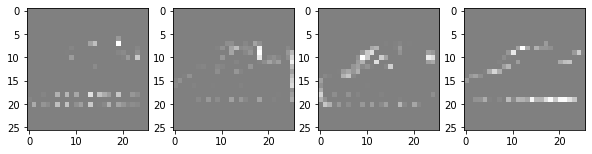

In [ ]:
# visualize a training image "sneaker_x" after it passes through the above four filters
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0] = plot_fig(ax[0], layer_output[:, :, :, 0].flatten(), (26, 26))
ax[1] = plot_fig(ax[1], layer_output[:, :, :, 1].flatten(), (26, 26))
ax[2] = plot_fig(ax[2], layer_output[:, :, :, 2].flatten(), (26, 26))
ax[3] = plot_fig(ax[3], layer_output[:, :, :, 3].flatten(), (26, 26))
plt.show()

In [ ]:
get_pool_layer_output = K.function([cnn_model.layers[0].input],
                                  [cnn_model.layers[1].output])
pool_output          = get_pool_layer_output(np.expand_dims(boot_x, axis=0))[0] 

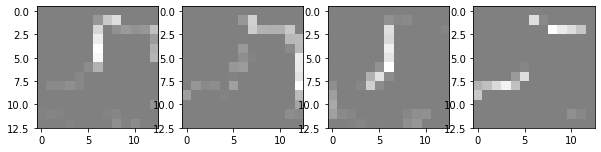

In [ ]:
# visualize the training image "boot_x" after it passes through the above four filters + pooling layer
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0] = plot_fig(ax[0], pool_output[:, :, :, 0].flatten(), (13, 13))
ax[1] = plot_fig(ax[1], pool_output[:, :, :, 1].flatten(), (13, 13))
ax[2] = plot_fig(ax[2], pool_output[:, :, :, 2].flatten(), (13, 13))
ax[3] = plot_fig(ax[3], pool_output[:, :, :, 3].flatten(), (13, 13))
plt.show()

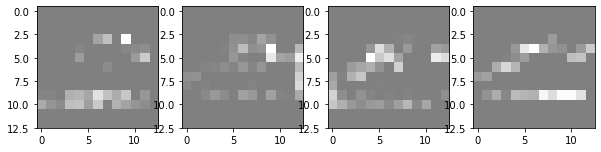

In [ ]:
pool_output          = get_pool_layer_output(np.expand_dims(sneaker_x, axis=0))[0] 
# visualize the training image "sneaker_x" after it passes through the above four filters + pooling layer
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0] = plot_fig(ax[0], pool_output[:, :, :, 0].flatten(), (13, 13))
ax[1] = plot_fig(ax[1], pool_output[:, :, :, 1].flatten(), (13, 13))
ax[2] = plot_fig(ax[2], pool_output[:, :, :, 2].flatten(), (13, 13))
ax[3] = plot_fig(ax[3], pool_output[:, :, :, 3].flatten(), (13, 13))
plt.show()

Through this notebook, we hope you can find the evidences that Conv-layer and pooling-layer in CNN are especailly suitable for feature extraction of image data.